# Example 3 - constant-velocity 1D position tracking

Kalman filters are extensively used in navigation and other GPS-based systems. These can be either linear or nonlinear. In the latter case, one usually resorts to the extended Kalman, filter (EKF) that is designed to deal better with nonlinear state equations---see below.

Process noise design for $Q$...
- diagonal
- constant velocity model
- constant acceleration model

We begin with a very simple case of tracking a 1D position due to constant velocity motion, described by

$$\frac{\mathrm{d}x}{\mathrm{d}t} = v, \quad x(0) = x_0.$$

This equation can be written as a system of two equations

$$\frac{\mathrm{d}\mathbf{x}}{\mathrm{d}t} = F \mathbf{x} + L \mathbf{w} , \quad \mathbf{x}(0) = \mathbf{x}_0,$$ 

where 

$$\mathbf{x}=\begin{bmatrix}x\\  \dot{x} \end{bmatrix},\quad
   F=\begin{bmatrix}0 & 1\\  0 & 0 \end{bmatrix},\quad 
   L=\begin{bmatrix}0\\  1  \end{bmatrix},\quad
   \mathbf{w}=w.$$

In discrete-time, we introduce a time-step, $\Delta t,$ that is sometimes just set equal to one, and obtain the discrete, state-space formulation

$$ \mathbf{x}_{k+1 } = F  \mathbf{x}_{k} + L w_k, $$

where

$$ 
   F=\begin{bmatrix}1 & \Delta t\\  0 & 1 \end{bmatrix},\quad 
   L=\begin{bmatrix} 1 \\  0  \end{bmatrix}.$$


We begin by simulating the motion and generating noisy measurements of the position.


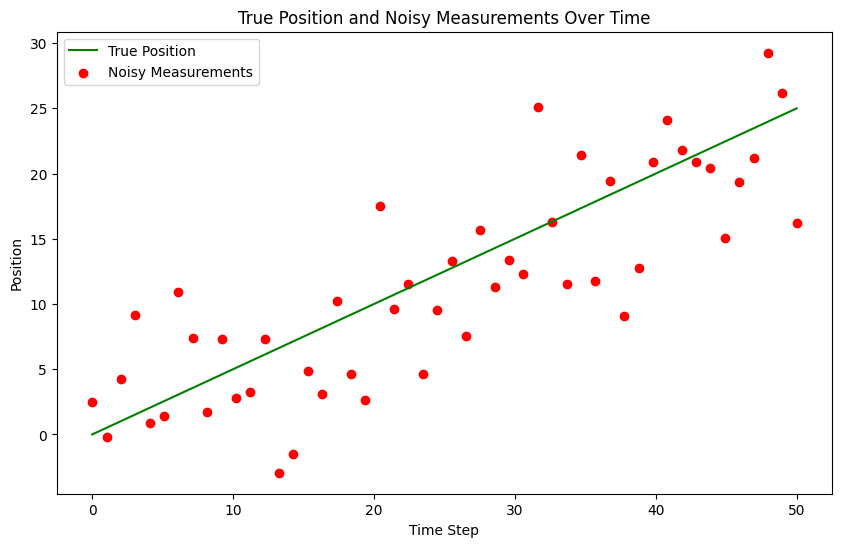

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Set the random seed for reproducibility
np.random.seed(42)

# Simulate the ground truth position of the object
true_velocity = 0.5  # units per time step
num_steps = 50
time_steps = np.linspace(0, num_steps, num_steps)
true_positions = true_velocity * time_steps

# Simulate the measurements with noise
measurement_noise = 5 #1#0  # increase this value to make measurements noisier
noisy_measurements = true_positions + np.random.normal(0, measurement_noise, num_steps)

# Plot the true positions and the noisy measurements
plt.figure(figsize=(10, 6))
plt.plot(time_steps, true_positions, label='True Position', color='green')
plt.scatter(time_steps, noisy_measurements, label='Noisy Measurements', color='red', marker='o')

plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('True Position and Noisy Measurements Over Time')
plt.legend()
plt.show()

Now, we set up the inputs for the Kalman filter, run it, and plot the results of the estimation.

The process noise covariance matrix, $Q,$ is taken here as

$$ 
  Q = \begin{bmatrix}1 & 0\\  0 & \sigma_w^2 \end{bmatrix},
$$

where we have supposed that 

$$
  w \sim \mathcal{N} (0, \sigma_w^2) . 
$$ 

This form for $Q$ can be derived from the discretization of a Wiener process, as shown in  {cite}Sarkka2023. We will consider a more general case in Example 4, below. 

In [2]:
sig_v = measurement_noise
sig_w = 0.1 # np.sqrt(3)  # process noise
# Kalman Filter Initialization
F = np.array([[1, 1], [0, 1]])        # State transition matrix
H = np.array([[1, 0]])                # Measurement function
Q = np.array([[1, 0], [0, sig_w**2]]) # Process noise covariance
R = np.array([[sig_v**2]])            # Measurement noise covariance
x0 = np.array([[0], [0]])             # Initial state estimate
P0 = np.array([[1, 0], [0, 1]])       # Initial estimate covariance

# Initialize the state estimate and covariance
nd = 2
T = 50

x_hat = np.zeros((T, nd, 1))
P     = np.zeros((T, nd, nd))

x_hat[0] = x0
P[0] = P0 #Q
y = noisy_measurements

# Run the Kalman filter
for t in range(1, T):
    # Prediction step
    x_hat[t] = F @ x_hat[t-1]
    P[t] = F @ P[t-1] @ F.T + Q

    # Update step
    K = P[t] @ H.T @ np.linalg.inv(H @ P[t] @ H.T + R)
    x_hat[t] = x_hat[t] + K @ (y[t] - H @ x_hat[t])
    P[t] = (np.eye(nd) - K @ H) @ P[t]

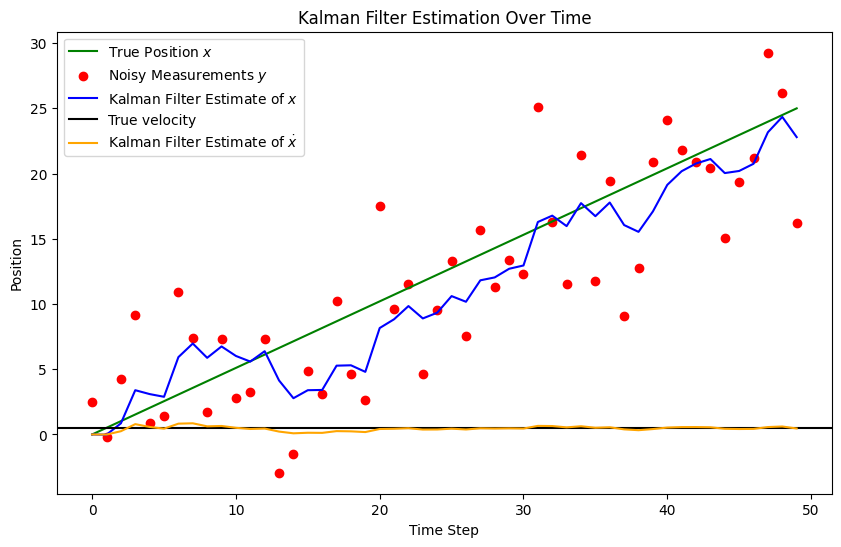

In [3]:
# Plot the true positions, noisy measurements, and the Kalman filter estimates
time_steps = range(T)
estimated_positions  = x_hat[:,0,:]
estimated_velocities = x_hat[:,1,:]
plt.figure(figsize=(10, 6))
plt.plot(time_steps, true_positions, label='True Position $x$', color='green')
plt.scatter(time_steps, noisy_measurements, label='Noisy Measurements $y$', color='red', marker='o')
plt.plot(time_steps, estimated_positions, label='Kalman Filter Estimate of $x$', color='blue')
plt.axhline(0.5,color='k',label='True velocity')
plt.plot(time_steps, estimated_velocities, label='Kalman Filter Estimate of $\dot{x}$', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('Kalman Filter Estimation Over Time')
plt.legend()
plt.show()